In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 32
learning_rate  = 1e-2
momentum = 0.5
epochs = 100

In [3]:
train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transforms.Compose([
                                transforms.Resize([224, 224]),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),                       # 数据类型转化
                                transforms.Normalize(
                                    (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # 数据归一化处理
                            ]))

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transforms.Compose([
                               transforms.Resize([224, 224]),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(15),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                           ]))

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
train_loader = torch.utils.data.DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False
)

In [6]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride):
        super(ResBlock, self).__init__()
        #这里定义了残差块内连续的2个卷积层
        self.normal = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channel != out_channel:
            #shortcut，这里为了跟2个卷积层的结果结构一致，要做处理
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel)
            )
            
    def forward(self, x):
        out = self.normal(x)
        #将2个卷积层的输出跟处理过的x相加，实现ResNet的基本结构
        out = out + self.shortcut(x)
        out = F.relu(out)
        
        return out

In [7]:
class ResNet18(nn.Module):
    def __init__(self, block=ResBlock, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64,
                      kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.layer1 = self.make_layer(block=block, channels=64, num_blocks=2, stride=1)
        self.layer2 = self.make_layer(block=block, channels=128, num_blocks=2, stride=2)
        self.layer3 = self.make_layer(block=block, channels=256, num_blocks=2, stride=2)
        self.layer4 = self.make_layer(block=block, channels=512, num_blocks=2, stride=2)
        self.fc = nn.Linear(512, num_classes)
    # 这个函数主要是用来，重复同一个残差块

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(in_channel=self.in_channels,
                                out_channel=channels, stride=stride))
            self.in_channels = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # 在这里，整个ResNet18的结构就很清晰了
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [8]:
net = ResNet18().to(DEVICE)
# net = models.resnet18().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.5, patience=3)

In [9]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()
        
        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    train_loss /= len(val_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [10]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('\nVAL set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))
    
    return val_loss, val_acc

In [11]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [12]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [13]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')

    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)

    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [14]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.465712
Train Epoch: 1 [3200/40000 (8%)]	Loss: 1.747472
Train Epoch: 1 [6400/40000 (16%)]	Loss: 1.587283
Train Epoch: 1 [9600/40000 (24%)]	Loss: 1.552454
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.794397
Train Epoch: 1 [16000/40000 (40%)]	Loss: 1.733955
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.420978
Train Epoch: 1 [22400/40000 (56%)]	Loss: 1.518492
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.587070
Train Epoch: 1 [28800/40000 (72%)]	Loss: 1.131052
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.359574
Train Epoch: 1 [35200/40000 (88%)]	Loss: 1.325925
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.270547

VAL set: Average loss: 0.0412, Accuracy: 5200.0/10000 (52.0%)

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.303667
Train Epoch: 2 [3200/40000 (8%)]	Loss: 1.339934
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.040767
Train Epoch: 2 [9600/40000 (24%)]	Loss: 1.341256
Train Epoch: 2 [12800/40000 (32%)]	Loss: 1.188348
Train Epoch: 2 [16000/40000 (40%)]	Loss: 1.186721
Trai

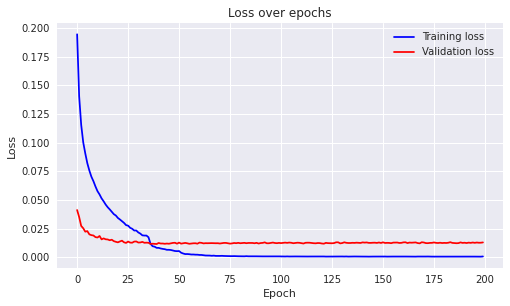

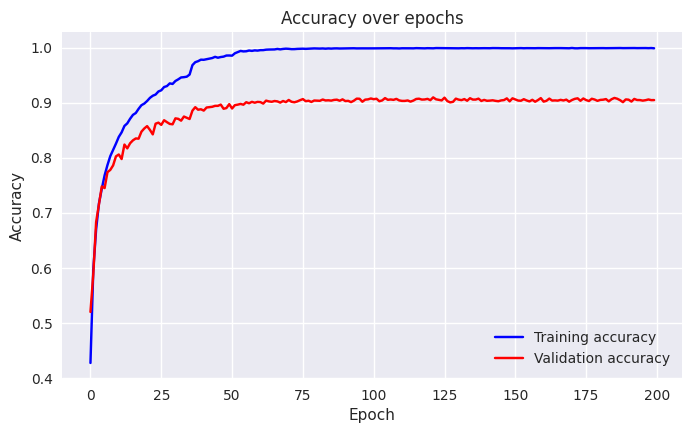

In [15]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'ResNet-18 - predictions')

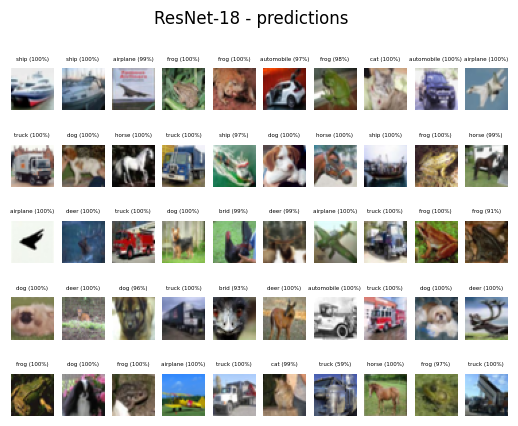

In [16]:
CIFAR_dict = {0: 'airplane',
              1: 'automobile',
              2: 'brid',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[int(torch.argmax(probs))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('ResNet-18 - predictions')


In [ ]:
"""
ResNet-18
Mine(batch_size = 32):
After 020 Epoch: 85.3%
After 040 Epoch: 88.8%
After 060 Epoch: 90.1%
After 080 Epoch: 90.4%
After 100 Epoch: 90.8%
After 120 Epoch: 90.7%
After 140 Epoch: 90.5%
After 160 Epoch: 90.8%
After 180 Epoch: 90.3%
After 200 Epoch: 90.5%
structure:
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 64, 56, 56]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,472
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
├─Sequential: 1-2                        [-1, 64, 56, 56]          --
|    └─ResBlock: 2-5                     [-1, 64, 56, 56]          --
|    |    └─Sequential: 3-1              [-1, 64, 56, 56]          73,984
|    |    └─Sequential: 3-2              [-1, 64, 56, 56]          --
|    └─ResBlock: 2-6                     [-1, 64, 56, 56]          --
|    |    └─Sequential: 3-3              [-1, 64, 56, 56]          73,984
|    |    └─Sequential: 3-4              [-1, 64, 56, 56]          --
├─Sequential: 1-3                        [-1, 128, 28, 28]         --
|    └─ResBlock: 2-7                     [-1, 128, 28, 28]         --
|    |    └─Sequential: 3-5              [-1, 128, 28, 28]         221,696
|    |    └─Sequential: 3-6              [-1, 128, 28, 28]         8,448
|    └─ResBlock: 2-8                     [-1, 128, 28, 28]         --
|    |    └─Sequential: 3-7              [-1, 128, 28, 28]         295,424
|    |    └─Sequential: 3-8              [-1, 128, 28, 28]         --
├─Sequential: 1-4                        [-1, 256, 14, 14]         --
|    └─ResBlock: 2-9                     [-1, 256, 14, 14]         --
|    |    └─Sequential: 3-9              [-1, 256, 14, 14]         885,760
|    |    └─Sequential: 3-10             [-1, 256, 14, 14]         33,280
|    └─ResBlock: 2-10                    [-1, 256, 14, 14]         --
|    |    └─Sequential: 3-11             [-1, 256, 14, 14]         1,180,672
|    |    └─Sequential: 3-12             [-1, 256, 14, 14]         --
├─Sequential: 1-5                        [-1, 512, 7, 7]           --
|    └─ResBlock: 2-11                    [-1, 512, 7, 7]           --
|    |    └─Sequential: 3-13             [-1, 512, 7, 7]           3,540,992
|    |    └─Sequential: 3-14             [-1, 512, 7, 7]           132,096
|    └─ResBlock: 2-12                    [-1, 512, 7, 7]           --
|    |    └─Sequential: 3-15             [-1, 512, 7, 7]           4,720,640
|    |    └─Sequential: 3-16             [-1, 512, 7, 7]           --
├─Linear: 1-6                            [-1, 10]                  5,130
==========================================================================================
Total params: 11,181,706
Trainable params: 11,181,706
Non-trainable params: 0
Total mult-adds (G): 1.85
==========================================================================================
Input size (MB): 0.57
Forward/backward pass size (MB): 37.90
Params size (MB): 42.65
Estimated Total Size (MB): 81.13
==========================================================================================
parameters_count: 11181706

Pytorch(batch_size = 32):
After 05 Epoch: 67.5%
After 10 Epoch: 76.3%
After 15 Epoch: 75.2%
After 20 Epoch: 79.2%
Pytorch(batch_size = 64):
After 05 Epoch: 67.5%
After 10 Epoch: 76.3%
After 15 Epoch: 75.2%
After 20 Epoch: 79.2%
ResNet-50
Pytorch(batch_size = 32):
After 05 Epoch: 67.5%
After 10 Epoch: 76.3%
After 15 Epoch: 75.2%
After 20 Epoch: 79.2%
"""